In [4]:
import glob
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from swap_strategy import create_qaoa_swap_circuit, SATMapper
from utils import load_graph_from_npy
from graph_to_ansatz import GraphAnsatzConverter
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy
import yaml
from qiskit import QuantumCircuit

base_path = "graphs"
index = "20241111"
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
swap_strategy_results = defaultdict(list)


In [15]:
def plot_swap_counts(results, label=None, color="blue"):
    keys = list(results.keys())
    means = [np.mean(values) for values in results.values()]
    std_devs = [np.std(values) for values in results.values()]

    plt.figure(figsize=(8, 6))
    plt.plot(keys, means, label=label, marker="o", linestyle="-", color=color)
    plt.fill_between(
        keys,
        [m - s for m, s in zip(means, std_devs)],
        [m + s for m, s in zip(means, std_devs)],
        color=color,
        alpha=0.2,
    )

    plt.xlabel("Qubits")
    plt.ylabel("Swap counts")
    plt.title("Swap counts vs. qubit counts")
    plt.legend()
    plt.grid(True)

    plt.show()

In [16]:
for n in range(4, 11):
    pattern = os.path.join(base_path, f"adj_matrix_{n}_*.npy")
    file_paths = glob.glob(pattern)
    for file_path in file_paths:
        g = load_graph_from_npy(file_path)
        swap_strategy = SwapStrategy.from_line(range(len(g.nodes())))
        sm = SATMapper(timeout=10)
        remapped_graph, edge_map, min_swap_layers = sm.remap_graph_with_sat(
            graph=g, swap_strategy=swap_strategy, max_layers=1
        )
        # print("Map from old to new nodes: ", edge_map)
        # print("Min SWAP layers:", min_swap_layers)
        converter = GraphAnsatzConverter(
            g if remapped_graph is None else remapped_graph
        )
        qaoa_circ = create_qaoa_swap_circuit(
            converter.hamiltonian, swap_strategy, qaoa_layers=1
        )
        depth = qaoa_circ.decompose(reps=1).depth(lambda instr: instr.name == "swap")
        # qaoa_circ.decompose(reps=1).draw(output="mpl")
        # swap_strategy_results[n].append(
        #     len(qaoa_circ.decompose(reps=1).get_instructions("swap"))
        # )
        swap_strategy_results[n].append(depth)

Layers: 0, Status: True, Time: 0.00010279999992235389
Layers: 0, Status: False, Time: 3.2400000009147334e-05
Layers: 0, Status: False, Time: 5.320000013853132e-05
Layers: 0, Status: False, Time: 5.710000004910398e-05
Layers: 0, Status: False, Time: 9.230000000570726e-05
Layers: 0, Status: True, Time: 7.470000014109246e-05
Layers: 0, Status: False, Time: 4.5300000010684016e-05
Layers: 0, Status: True, Time: 5.7200000128432293e-05
Layers: 0, Status: True, Time: 8.389999993596575e-05
Layers: 0, Status: True, Time: 6.289999987529882e-05
Layers: 0, Status: True, Time: 3.689999994094251e-05
Layers: 0, Status: False, Time: 8.379999985663744e-05
Layers: 0, Status: True, Time: 7.660000005671463e-05
Layers: 0, Status: True, Time: 5.03999999637017e-05
Layers: 0, Status: True, Time: 3.5399999887886224e-05
Layers: 0, Status: False, Time: 0.0001746000000366621
Layers: 0, Status: True, Time: 3.3799999982875306e-05
Layers: 0, Status: True, Time: 0.0006593000000520988
Layers: 0, Status: False, Time: 3.

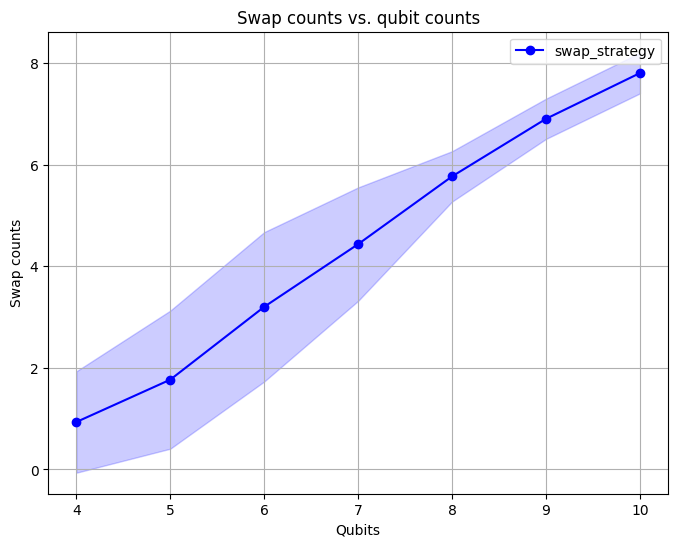

In [17]:
plot_swap_counts(swap_strategy_results, label="swap_strategy")

In [9]:
ai_results = defaultdict(list)

In [12]:
import tensorflow as tf
from rl import game
# qubits = config["game_settings"]["N"]
for qubits in range(6,11):
    game.initialize_game(qubits)
    pattern = os.path.join(base_path, f"adj_matrix_{qubits}_*.npy")
    file_paths = glob.glob(pattern)
    if qubits == 4:
        training_steps = 200
    elif qubits == 5:
        training_steps = 500
    elif qubits == 6:
        training_steps = 700
    elif qubits == 7:
        training_steps = 700
    else:
        training_steps = 800
    network = tf.keras.models.load_model(f"checkpoints/network{qubits}_{index}_{training_steps}")
    for file_path in file_paths:
        trial = 0
        min_depth = float("inf")
        while trial < 10:
            state = np.load(file_path)
            ans = []
            done = False
            total_score = 0
            step_count = 0
            prev_action = None
            while not done and step_count < 50:
                encoded_state = game.encode_state(state,qubits)
                input_state = np.expand_dims(encoded_state, axis=0)

                policy_output, value_output = network.predict(input_state)
                policy = policy_output[0]
                if prev_action is not None:
                    indices = [i for i in range(game.ACTION_SPACE) if i != prev_action]

                    prob = policy[indices]
                    action = np.random.choice(indices, p=prob / prob.sum())
                else:
                    indices = list(range(game.ACTION_SPACE))
                    action = np.random.choice(indices, p=policy)
                selected_action = game.ACTIONS[action]
                # print(f"Step {step_count}: Selected action {selected_action}")
                ans.append(selected_action)
                # アクションの適用
                state, done, _ = game.step(state, action, prev_action)
                prev_action = action
                step_count += 1
            qc = QuantumCircuit(qubits)
            for swap in ans:
                qc.swap(*swap)
            depth = qc.depth(lambda instr: instr.name == "swap")
            min_depth = min(depth,min_depth)
            trial += 1
        ai_results[qubits].append(min_depth)
        # ai_results[qubits].append(len(ans))
ai_results

1/1 [==============================] - 0s 21ms/step


defaultdict(list,
            {5: [2,
              2,
              3,
              2,
              3,
              3,
              2,
              3,
              2,
              4,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              1,
              3,
              2,
              2,
              2,
              2,
              2,
              2,
              3],
             6: [3,
              2,
              3,
              3,
              4,
              3,
              2,
              6,
              4,
              4,
              6,
              5,
              2,
              2,
              2,
              3,
              4,
              2,
              5,
              1,
              5,
              4,
              4,
              6,
              3,
              4,
              3,
      

In [13]:
ai_results

defaultdict(list,
            {5: [2,
              2,
              3,
              2,
              3,
              3,
              2,
              3,
              2,
              4,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              1,
              3,
              2,
              2,
              2,
              2,
              2,
              2,
              3],
             6: [3,
              2,
              3,
              3,
              4,
              3,
              2,
              6,
              4,
              4,
              6,
              5,
              2,
              2,
              2,
              3,
              4,
              2,
              5,
              1,
              5,
              4,
              4,
              6,
              3,
              4,
              3,
      

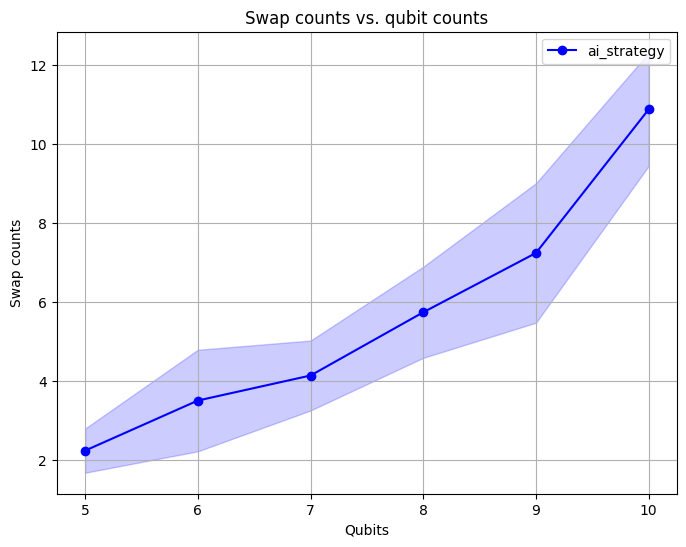

In [18]:
plot_swap_counts(ai_results, label="ai_strategy")

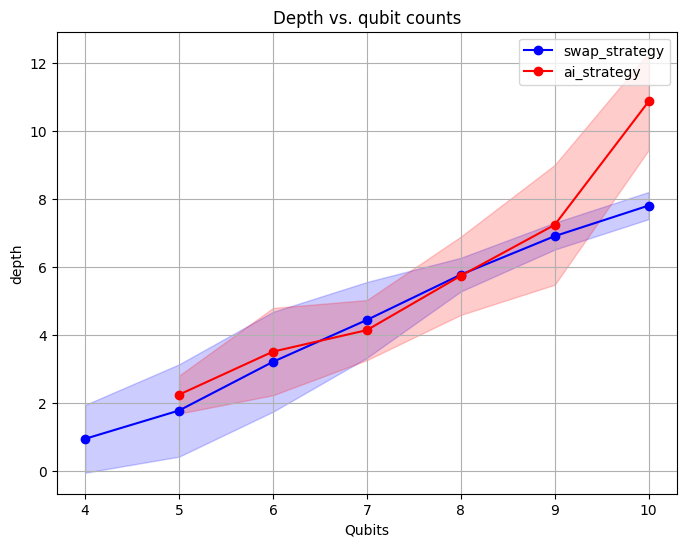

In [19]:
def plot_swap_counts_combined(*results_list, labels=None, colors=None):

    plt.figure(figsize=(8, 6))
    for i, results in enumerate(results_list):
        label = labels[i] if labels and i < len(labels) else f"Strategy {i+1}"
        color = colors[i] if colors and i < len(colors) else None
        keys = list(results.keys())
        means = [np.mean(values) for values in results.values()]
        std_devs = [np.std(values) for values in results.values()]
        plt.plot(keys, means, label=label, marker="o", linestyle="-", color=color)
        plt.fill_between(
            keys,
            [m - s for m, s in zip(means, std_devs)],
            [m + s for m, s in zip(means, std_devs)],
            color=color,
            alpha=0.2,
        )
    plt.xlabel("Qubits")
    plt.ylabel("depth")
    plt.title("Depth vs. qubit counts")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_swap_counts_combined(
    swap_strategy_results,
    ai_results,
    labels=["swap_strategy", "ai_strategy"],
    colors=["blue", "red"]
)